# gRNA Classification: Model Training & Biological Interpretation

## 🎯 Goals

1. **Maximum Accuracy**: Train and optimize multiple models
2. **Biological Interpretability**: Understand what the model learns

## 📋 Pipeline

1. **Data Loading & Exploration** - Verify prepared datasets
2. **Baseline Models** - Random Forest, XGBoost, Logistic Regression
3. **Hyperparameter Tuning** - Optimize best performers
4. **Feature Importance Analysis** - Identify key biological features
5. **Biological Validation** - Compare with Cooper et al. 2022
6. **Error Analysis** - Understand model mistakes
7. **Final Model & Export** - Save best model for predictions

## 🔬 Expected Biological Features (from Cooper et al. 2022)

| Feature | Biological Meaning | Expected Importance |
|---------|-------------------|--------------------|
| Initiation patterns (AAAA, GAAA) | Transcription start | HIGH |
| Anchor AC-rich, G-depleted | mRNA binding, prevents GU wobble | HIGH |
| Guide A-elevated (>40%) | Editing information | MEDIUM-HIGH |
| Terminal T | U-tail addition | MEDIUM |
| Molecular ruler (15-19 nt) | Init+anchor conservation | MEDIUM |

---

## Setup & Imports

In [1]:
import warnings
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance
import joblib

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not installed. Run: pip install xgboost")

# LightGBM (optional)
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

# SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not installed. Run: pip install shap (for advanced interpretability)")

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

print("✓ Imports loaded")
print(f"  XGBoost: {'✓' if XGBOOST_AVAILABLE else '✗'}")
print(f"  LightGBM: {'✓' if LIGHTGBM_AVAILABLE else '✗'}")
print(f"  SHAP: {'✓' if SHAP_AVAILABLE else '✗'}")

✓ Imports loaded
  XGBoost: ✓
  LightGBM: ✓
  SHAP: ✓


### Define Paths

In [2]:
# Update these paths for your environment!
PROJECT_ROOT = Path.home() / 'projects' / 'grna-inspector'
DATA_DIR = PROJECT_ROOT / 'data' / 'processed' / 'comprehensive_pipeline'
MODELS_DIR = PROJECT_ROOT / 'models'
PLOTS_DIR = PROJECT_ROOT / 'data' / 'plots' / 'model_analysis'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Plots directory: {PLOTS_DIR}")

Data directory: /Users/anna/projects/grna-inspector/data/processed/comprehensive_pipeline
Models directory: /Users/anna/projects/grna-inspector/models
Plots directory: /Users/anna/projects/grna-inspector/data/plots/model_analysis


---
## 1. Load & Verify Data

In [3]:
print("="*80)
print("STAGE 1: LOAD & VERIFY DATA")
print("="*80)

# Load datasets
train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
val_df = pd.read_csv(DATA_DIR / 'val_data.csv')
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

print(f"\n📊 Dataset sizes:")
print(f"  Train: {len(train_df):,}")
print(f"  Val:   {len(val_df):,}")
print(f"  Test:  {len(test_df):,}")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df):,}")

# Load feature names
with open(DATA_DIR / 'feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"\n📋 Features: {len(feature_names)}")

# Verify no length leakage
if 'length' in feature_names:
    print("\n❌ WARNING: 'length' in features - removing!")
    feature_names.remove('length')
else:
    print("\n✓ Length correctly excluded from features")

# Class balance
print("\n📊 Class distribution:")
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    pos = sum(df['label'] == 1)
    neg = sum(df['label'] == 0)
    print(f"  {name}: pos={pos}, neg={neg}, ratio={pos/neg:.2f}")

STAGE 1: LOAD & VERIFY DATA

📊 Dataset sizes:
  Train: 1,621
  Val:   347
  Test:  348
  Total: 2,316

📋 Features: 120

✓ Length correctly excluded from features

📊 Class distribution:
  Train: pos=811, neg=810, ratio=1.00
  Val: pos=173, neg=174, ratio=0.99
  Test: pos=174, neg=174, ratio=1.00


In [4]:
# Prepare feature matrices
X_train = train_df[feature_names].values
y_train = train_df['label'].values

X_val = val_df[feature_names].values
y_val = val_df['label'].values

X_test = test_df[feature_names].values
y_test = test_df['label'].values

# Combined train+val for final training
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

print(f"\n✓ Feature matrices prepared:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  X_trainval: {X_trainval.shape}")


✓ Feature matrices prepared:
  X_train: (1621, 120)
  X_val: (347, 120)
  X_test: (348, 120)
  X_trainval: (1968, 120)


---
## 2. Baseline Models Comparison

Train multiple models with default parameters to establish baselines.

In [5]:
def evaluate_model(model, X, y, dataset_name=""):
    """
    Evaluate model and return metrics dict.
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
    }
    
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y, y_proba)
        metrics['avg_precision'] = average_precision_score(y, y_proba)
    
    return metrics, y_pred, y_proba


def print_metrics(metrics, name=""):
    """Print metrics nicely."""
    print(f"\n  {name}:")
    print(f"    Accuracy:  {metrics['accuracy']:.4f}")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall:    {metrics['recall']:.4f}")
    print(f"    F1-score:  {metrics['f1']:.4f}")
    if 'roc_auc' in metrics:
        print(f"    ROC-AUC:   {metrics['roc_auc']:.4f}")

In [6]:
print("="*80)
print("STAGE 2: BASELINE MODELS COMPARISON")
print("="*80)

# Define models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42
    ),
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

# Add LightGBM if available
if LIGHTGBM_AVAILABLE:
    models['LightGBM'] = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    )

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate all models
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print('='*60)
    
    # Use scaled data for Logistic Regression
    if 'Logistic' in name:
        X_tr, X_v, X_te = X_train_scaled, X_val_scaled, X_test_scaled
    else:
        X_tr, X_v, X_te = X_train, X_val, X_test
    
    # Train
    model.fit(X_tr, y_train)
    trained_models[name] = model
    
    # Evaluate on train, val, test
    train_metrics, _, _ = evaluate_model(model, X_tr, y_train)
    val_metrics, _, _ = evaluate_model(model, X_v, y_val)
    test_metrics, y_pred, y_proba = evaluate_model(model, X_te, y_test)
    
    print_metrics(train_metrics, "Train")
    print_metrics(val_metrics, "Validation")
    print_metrics(test_metrics, "Test")
    
    results[name] = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }

print("\n" + "="*80)
print("✓ All baseline models trained!")
print("="*80)

STAGE 2: BASELINE MODELS COMPARISON

Training: Random Forest

  Train:
    Accuracy:  1.0000
    Precision: 1.0000
    Recall:    1.0000
    F1-score:  1.0000
    ROC-AUC:   1.0000

  Validation:
    Accuracy:  0.9510
    Precision: 0.9432
    Recall:    0.9595
    F1-score:  0.9513
    ROC-AUC:   0.9898

  Test:
    Accuracy:  0.9339
    Precision: 0.9314
    Recall:    0.9368
    F1-score:  0.9341
    ROC-AUC:   0.9852

Training: Gradient Boosting

  Train:
    Accuracy:  1.0000
    Precision: 1.0000
    Recall:    1.0000
    F1-score:  1.0000
    ROC-AUC:   1.0000

  Validation:
    Accuracy:  0.9539
    Precision: 0.9290
    Recall:    0.9827
    F1-score:  0.9551
    ROC-AUC:   0.9930

  Test:
    Accuracy:  0.9511
    Precision: 0.9337
    Recall:    0.9713
    F1-score:  0.9521
    ROC-AUC:   0.9856

Training: Logistic Regression

  Train:
    Accuracy:  0.9692
    Precision: 0.9680
    Recall:    0.9704
    F1-score:  0.9692
    ROC-AUC:   0.9938

  Validation:
    Accuracy:  0

In [7]:
# Summary comparison table
print("\n" + "="*80)
print("BASELINE COMPARISON SUMMARY (Test Set)")
print("="*80 + "\n")

summary_data = []
for name, res in results.items():
    test = res['test']
    summary_data.append({
        'Model': name,
        'Accuracy': test['accuracy'],
        'Precision': test['precision'],
        'Recall': test['recall'],
        'F1': test['f1'],
        'ROC-AUC': test.get('roc_auc', np.nan)
    })

summary_df = pd.DataFrame(summary_data).sort_values('F1', ascending=False)
print(summary_df.to_string(index=False))

# Best model
best_model_name = summary_df.iloc[0]['Model']
best_f1 = summary_df.iloc[0]['F1']
print(f"\n🏆 Best baseline: {best_model_name} (F1 = {best_f1:.4f})")


BASELINE COMPARISON SUMMARY (Test Set)

              Model  Accuracy  Precision   Recall       F1  ROC-AUC
  Gradient Boosting  0.951149   0.933702 0.971264 0.952113 0.985632
            XGBoost  0.942529   0.927778 0.959770 0.943503 0.989133
           LightGBM  0.939655   0.913514 0.971264 0.941504 0.988109
Logistic Regression  0.939655   0.918033 0.965517 0.941176 0.986095
      Random Forest  0.933908   0.931429 0.936782 0.934097 0.985153

🏆 Best baseline: Gradient Boosting (F1 = 0.9521)


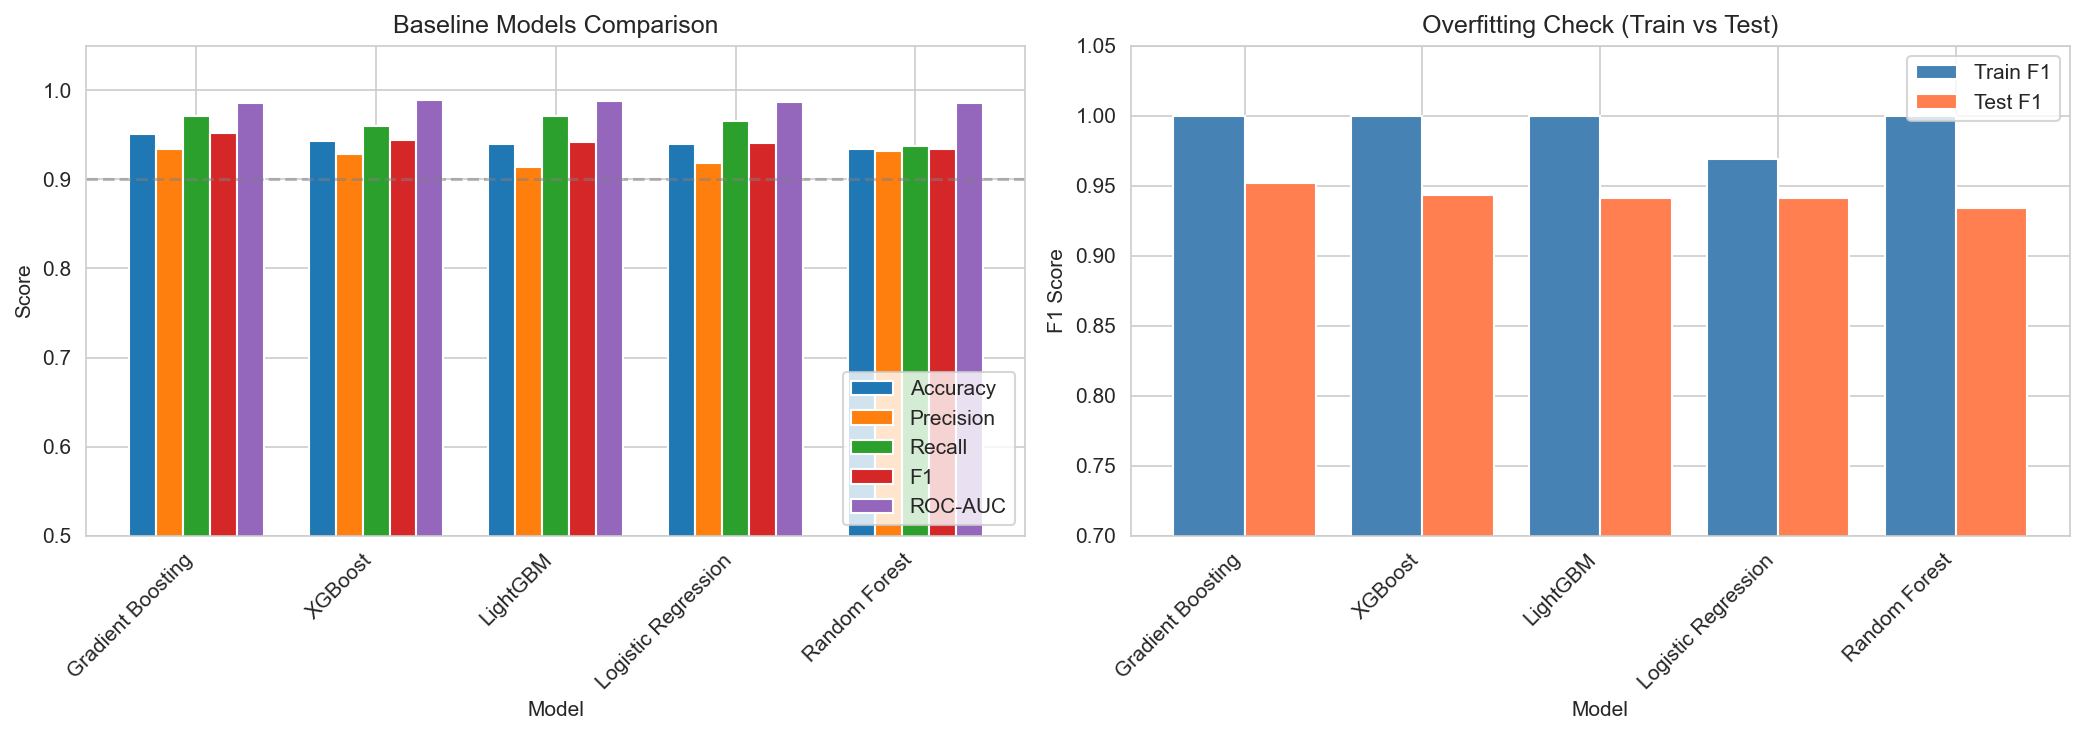


✓ Plot saved


In [8]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x = np.arange(len(summary_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, summary_df[metric], width, label=metric)

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Baseline Models Comparison')
axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(summary_df['Model'], rotation=45, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0.5, 1.05)
axes[0].axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)

# Train vs Test (overfitting check)
train_f1 = [results[m]['train']['f1'] for m in summary_df['Model']]
test_f1 = [results[m]['test']['f1'] for m in summary_df['Model']]

x = np.arange(len(summary_df))
axes[1].bar(x - 0.2, train_f1, 0.4, label='Train F1', color='steelblue')
axes[1].bar(x + 0.2, test_f1, 0.4, label='Test F1', color='coral')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Overfitting Check (Train vs Test)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(summary_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(0.7, 1.05)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved")

---
## 3. Hyperparameter Tuning (Best Models)

Optimize the top 2 performers.

In [ ]:
print("="*80)
print("STAGE 3: HYPERPARAMETER TUNING")
print("="*80)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest tuning
print("\n[1/2] Tuning Random Forest...")

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Use RandomizedSearchCV for faster search
from sklearn.model_selection import RandomizedSearchCV

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    n_iter=50,
    cv=cv,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_trainval, y_trainval)

print(f"\n  Best params: {rf_search.best_params_}")
print(f"  Best CV F1: {rf_search.best_score_:.4f}")

best_rf = rf_search.best_estimator_

STAGE 3: HYPERPARAMETER TUNING

[1/2] Tuning Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
# XGBoost tuning (if available)
if XGBOOST_AVAILABLE:
    print("\n[2/2] Tuning XGBoost...")
    
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2]
    }
    
    xgb_search = RandomizedSearchCV(
        xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        xgb_param_grid,
        n_iter=50,
        cv=cv,
        scoring='f1',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    xgb_search.fit(X_trainval, y_trainval)
    
    print(f"\n  Best params: {xgb_search.best_params_}")
    print(f"  Best CV F1: {xgb_search.best_score_:.4f}")
    
    best_xgb = xgb_search.best_estimator_
else:
    best_xgb = None
    print("\n[2/2] Skipping XGBoost (not available)")

In [ ]:
# Evaluate tuned models on test set
print("\n" + "="*60)
print("TUNED MODELS - TEST SET EVALUATION")
print("="*60)

tuned_results = {}

# Random Forest
rf_metrics, rf_pred, rf_proba = evaluate_model(best_rf, X_test, y_test)
print_metrics(rf_metrics, "Random Forest (tuned)")
tuned_results['Random Forest (tuned)'] = rf_metrics

# XGBoost
if best_xgb is not None:
    xgb_metrics, xgb_pred, xgb_proba = evaluate_model(best_xgb, X_test, y_test)
    print_metrics(xgb_metrics, "XGBoost (tuned)")
    tuned_results['XGBoost (tuned)'] = xgb_metrics

# Select best final model
if best_xgb is not None and xgb_metrics['f1'] > rf_metrics['f1']:
    final_model = best_xgb
    final_model_name = 'XGBoost'
    final_metrics = xgb_metrics
    final_pred = xgb_pred
    final_proba = xgb_proba
else:
    final_model = best_rf
    final_model_name = 'Random Forest'
    final_metrics = rf_metrics
    final_pred = rf_pred
    final_proba = rf_proba

print(f"\n🏆 Best tuned model: {final_model_name}")
print(f"   F1 = {final_metrics['f1']:.4f}, ROC-AUC = {final_metrics['roc_auc']:.4f}")

---
## 4. Feature Importance Analysis

### 🔬 Critical Step: Verify the model learns BIOLOGY, not artifacts!

In [ ]:
print("="*80)
print("STAGE 4: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importances from the final model
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
else:
    # For models without built-in importance, use permutation importance
    perm_importance = permutation_importance(final_model, X_test, y_test, 
                                              n_repeats=10, random_state=42)
    importances = perm_importance.importances_mean

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n📊 Top 30 Most Important Features:")
print("="*60)
for i, row in importance_df.head(30).iterrows():
    feat = row['feature']
    imp = row['importance']
    
    # Mark biological significance
    bio_marker = ""
    if 'anchor' in feat.lower():
        bio_marker = "⭐ [Anchor]"
    elif 'init' in feat.lower():
        bio_marker = "⭐ [Initiation]"
    elif 'guide' in feat.lower():
        bio_marker = "⭐ [Guiding]"
    elif 'end' in feat.lower() or 'last' in feat.lower() or 'terminal' in feat.lower():
        bio_marker = "⭐ [Terminal]"
    elif 'molecular_ruler' in feat.lower() or 'grna_signature' in feat.lower():
        bio_marker = "⭐ [Combined]"
    
    print(f"  {imp:.4f}  {feat:40s} {bio_marker}")

In [ ]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 25 features
top_n = 25
top_features = importance_df.head(top_n)

# Color by biological category
def get_category(feature_name):
    if 'anchor' in feature_name.lower():
        return 'Anchor Region'
    elif 'init' in feature_name.lower():
        return 'Initiation'
    elif 'guide' in feature_name.lower():
        return 'Guiding Region'
    elif any(x in feature_name.lower() for x in ['end', 'last', 'terminal']):
        return 'Terminal'
    elif any(x in feature_name.lower() for x in ['kmer', 'dinuc']):
        return 'K-mer/Dinuc'
    elif any(x in feature_name.lower() for x in ['global', 'entropy', 'complexity']):
        return 'Global/Structural'
    else:
        return 'Other'

top_features = top_features.copy()
top_features['category'] = top_features['feature'].apply(get_category)

category_colors = {
    'Anchor Region': '#2ecc71',
    'Initiation': '#3498db',
    'Guiding Region': '#9b59b6',
    'Terminal': '#e74c3c',
    'K-mer/Dinuc': '#f39c12',
    'Global/Structural': '#1abc9c',
    'Other': '#95a5a6'
}

colors = [category_colors[cat] for cat in top_features['category']]

axes[0].barh(range(top_n), top_features['importance'].values[::-1], color=colors[::-1])
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features['feature'].values[::-1])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Top {top_n} Feature Importance ({final_model_name})')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=cat) 
                   for cat, color in category_colors.items()]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=8)

# Category distribution
category_importance = top_features.groupby('category')['importance'].sum().sort_values(ascending=True)
axes[1].barh(category_importance.index, category_importance.values, 
             color=[category_colors[c] for c in category_importance.index])
axes[1].set_xlabel('Total Importance')
axes[1].set_title('Importance by Feature Category (Top 25)')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved")

In [ ]:
# Biological validation: Check if key features are important
print("\n" + "="*60)
print("🔬 BIOLOGICAL VALIDATION")
print("="*60)

# Expected important features based on Cooper et al. 2022
expected_features = {
    'Initiation patterns': ['init_has_AAAA', 'init_has_GAAA', 'init_has_AGAA', 
                            'init_any_known_pattern', 'init_4_A_rich'],
    'Anchor composition': ['anchor_AC_rich', 'anchor_G_depleted', 'anchor_AC_content',
                           'anchor_G_freq', 'anchor_AC_very_rich'],
    'Molecular ruler': ['in_molecular_ruler_range', 'init_anchor_total_len'],
    'Guiding region': ['guide_A_elevated', 'guide_A_freq', 'guide_A_content_high'],
    'Terminal T': ['ends_with_T', 'last3_T_count', 'last5_T_freq'],
    'Meta-features': ['grna_signature_count', 'grna_signature_all', 'init_anchor_quality']
}

# Check importance rankings
importance_df_indexed = importance_df.set_index('feature')

print("\nExpected vs Actual Feature Importance:")
print("-"*60)

for category, features in expected_features.items():
    print(f"\n{category}:")
    for feat in features:
        if feat in importance_df_indexed.index:
            rank = importance_df.index[importance_df['feature'] == feat].tolist()[0] + 1
            imp = importance_df_indexed.loc[feat, 'importance']
            status = "✓" if rank <= 50 else "⚠️"
            print(f"  {status} {feat:35s} Rank: {rank:3d}  Imp: {imp:.4f}")
        else:
            print(f"  ✗ {feat:35s} NOT FOUND")

In [ ]:
# SHAP analysis (if available) for deeper interpretation
if SHAP_AVAILABLE:
    print("\n" + "="*60)
    print("SHAP ANALYSIS (Deep Interpretability)")
    print("="*60)
    
    # Create SHAP explainer
    if 'XGBoost' in final_model_name or 'Random Forest' in final_model_name:
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test)
        
        # For binary classification, get values for positive class
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        
        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, 
                         show=False, max_display=20)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'shap_summary.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Bar plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                         plot_type='bar', show=False, max_display=20)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'shap_bar.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\n✓ SHAP plots saved")
else:
    print("\n⚠️ SHAP not available. Install with: pip install shap")

---
## 5. Detailed Error Analysis

Understand what the model gets wrong and why.

In [ ]:
print("="*80)
print("STAGE 5: ERROR ANALYSIS")
print("="*80)

# Confusion matrix
cm = confusion_matrix(y_test, final_pred)
tn, fp, fn, tp = cm.ravel()

print("\n📊 Confusion Matrix:")
print(f"                 Predicted")
print(f"                 Neg    Pos")
print(f"  Actual Neg    {tn:4d}   {fp:4d}")
print(f"  Actual Pos    {fn:4d}   {tp:4d}")

print(f"\n  True Negatives:  {tn} (correctly rejected non-gRNA)")
print(f"  True Positives:  {tp} (correctly identified gRNA)")
print(f"  False Positives: {fp} (non-gRNA classified as gRNA)")
print(f"  False Negatives: {fn} (gRNA missed)")

In [ ]:
# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted Neg', 'Predicted Pos'],
            yticklabels=['Actual Neg', 'Actual Pos'])
axes[0].set_title(f'Confusion Matrix ({final_model_name})')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, final_proba)
roc_auc = roc_auc_score(y_test, final_proba)

axes[1].plot(fpr, tpr, 'b-', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'confusion_and_roc.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Analyze errors in detail
test_df_with_pred = test_df.copy()
test_df_with_pred['predicted'] = final_pred
test_df_with_pred['probability'] = final_proba
test_df_with_pred['correct'] = test_df_with_pred['label'] == test_df_with_pred['predicted']
test_df_with_pred['error_type'] = 'Correct'
test_df_with_pred.loc[(test_df_with_pred['label'] == 1) & (test_df_with_pred['predicted'] == 0), 'error_type'] = 'False Negative'
test_df_with_pred.loc[(test_df_with_pred['label'] == 0) & (test_df_with_pred['predicted'] == 1), 'error_type'] = 'False Positive'

# False Negatives - gRNAs that were missed
false_negatives = test_df_with_pred[test_df_with_pred['error_type'] == 'False Negative']

# False Positives - non-gRNAs classified as gRNA
false_positives = test_df_with_pred[test_df_with_pred['error_type'] == 'False Positive']

print("\n" + "="*60)
print("FALSE NEGATIVE ANALYSIS (Missed gRNAs)")
print("="*60)
print(f"\nTotal: {len(false_negatives)}")

if len(false_negatives) > 0:
    # Compare key features
    correct_positives = test_df_with_pred[(test_df_with_pred['label'] == 1) & (test_df_with_pred['correct'])]
    
    key_features = ['init_any_known_pattern', 'anchor_AC_rich', 'guide_A_elevated', 
                    'ends_with_T', 'grna_signature_count']
    
    print("\nKey feature comparison (FN vs Correct Positives):")
    for feat in key_features:
        if feat in test_df_with_pred.columns:
            fn_mean = false_negatives[feat].mean()
            cp_mean = correct_positives[feat].mean()
            diff = fn_mean - cp_mean
            print(f"  {feat:30s}  FN: {fn_mean:.3f}  CP: {cp_mean:.3f}  Δ: {diff:+.3f}")

In [ ]:
print("\n" + "="*60)
print("FALSE POSITIVE ANALYSIS (Non-gRNAs misclassified)")
print("="*60)
print(f"\nTotal: {len(false_positives)}")

if len(false_positives) > 0:
    # Source breakdown
    print("\nBy source:")
    for source, count in false_positives['source'].value_counts().items():
        pct = count / len(false_positives) * 100
        print(f"  {source}: {count} ({pct:.1f}%)")
    
    # Compare key features
    correct_negatives = test_df_with_pred[(test_df_with_pred['label'] == 0) & (test_df_with_pred['correct'])]
    
    print("\nKey feature comparison (FP vs Correct Negatives):")
    for feat in key_features:
        if feat in test_df_with_pred.columns:
            fp_mean = false_positives[feat].mean()
            cn_mean = correct_negatives[feat].mean()
            diff = fp_mean - cn_mean
            print(f"  {feat:30s}  FP: {fp_mean:.3f}  CN: {cn_mean:.3f}  Δ: {diff:+.3f}")

In [ ]:
# Visualize error distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Probability distribution by true label
for label, name, color in [(0, 'Non-gRNA', 'coral'), (1, 'gRNA', 'steelblue')]:
    subset = test_df_with_pred[test_df_with_pred['label'] == label]
    axes[0, 0].hist(subset['probability'], bins=30, alpha=0.6, label=name, color=color)
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[0, 0].set_xlabel('Predicted Probability')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Probability Distribution by True Label')
axes[0, 0].legend()

# 2. Key feature comparison
feature_to_plot = 'grna_signature_count'
if feature_to_plot in test_df_with_pred.columns:
    for error_type, color in [('Correct', 'green'), ('False Negative', 'red'), ('False Positive', 'orange')]:
        subset = test_df_with_pred[test_df_with_pred['error_type'] == error_type]
        if len(subset) > 0:
            axes[0, 1].hist(subset[feature_to_plot], bins=10, alpha=0.6, label=error_type, color=color)
    axes[0, 1].set_xlabel(feature_to_plot)
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title(f'{feature_to_plot} by Error Type')
    axes[0, 1].legend()

# 3. Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, final_proba)
avg_prec = average_precision_score(y_test, final_proba)
axes[1, 0].plot(recall, precision, 'b-', lw=2, label=f'AP = {avg_prec:.4f}')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].legend()
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1.05])

# 4. Threshold analysis
thresholds_to_test = np.arange(0.3, 0.8, 0.05)
f1_scores = []
precisions = []
recalls = []

for thresh in thresholds_to_test:
    pred_at_thresh = (final_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, pred_at_thresh))
    precisions.append(precision_score(y_test, pred_at_thresh))
    recalls.append(recall_score(y_test, pred_at_thresh))

axes[1, 1].plot(thresholds_to_test, f1_scores, 'b-', lw=2, label='F1')
axes[1, 1].plot(thresholds_to_test, precisions, 'g--', lw=2, label='Precision')
axes[1, 1].plot(thresholds_to_test, recalls, 'r--', lw=2, label='Recall')
axes[1, 1].axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Metrics vs Classification Threshold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Final Model & Export

In [ ]:
print("="*80)
print("STAGE 6: SAVE FINAL MODEL")
print("="*80)

# Save the model
model_path = MODELS_DIR / f'grna_classifier_{final_model_name.lower().replace(" ", "_")}.joblib'
joblib.dump(final_model, model_path)
print(f"\n✓ Model saved: {model_path}")

# Save the scaler (for Logistic Regression compatibility)
scaler_path = MODELS_DIR / 'feature_scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved: {scaler_path}")

# Save feature names
feature_path = MODELS_DIR / 'feature_names.json'
with open(feature_path, 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"✓ Feature names saved: {feature_path}")

# Save feature importance
importance_path = MODELS_DIR / 'feature_importance.csv'
importance_df.to_csv(importance_path, index=False)
print(f"✓ Feature importance saved: {importance_path}")

# Save model metadata
metadata = {
    'model_type': final_model_name,
    'training_date': datetime.now().isoformat(),
    'n_features': len(feature_names),
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'test_metrics': final_metrics,
    'best_params': rf_search.best_params_ if 'Random Forest' in final_model_name else 
                   (xgb_search.best_params_ if best_xgb is not None else {}),
    'top_10_features': importance_df.head(10)['feature'].tolist()
}

metadata_path = MODELS_DIR / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved: {metadata_path}")

In [ ]:
# Final summary
print("\n" + "="*80)
print("🎯 FINAL SUMMARY")
print("="*80)

print(f"\n🏆 Best Model: {final_model_name}")
print(f"\n📊 Test Set Performance:")
print(f"   Accuracy:  {final_metrics['accuracy']:.4f}")
print(f"   Precision: {final_metrics['precision']:.4f}")
print(f"   Recall:    {final_metrics['recall']:.4f}")
print(f"   F1-score:  {final_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {final_metrics['roc_auc']:.4f}")

print(f"\n🔬 Top 10 Important Features:")
for i, row in importance_df.head(10).iterrows():
    print(f"   {i+1:2d}. {row['feature']}")

print(f"\n📁 Saved Files:")
print(f"   - {model_path}")
print(f"   - {scaler_path}")
print(f"   - {feature_path}")
print(f"   - {importance_path}")
print(f"   - {metadata_path}")

print(f"\n📊 Plots saved to: {PLOTS_DIR}")

print("\n" + "="*80)
print("✅ MODEL TRAINING COMPLETE!")
print("="*80)

---
## 7. Quick Prediction Example

How to use the saved model for new predictions.

In [ ]:
# Example: Load and use the saved model
print("="*80)
print("EXAMPLE: USING THE SAVED MODEL")
print("="*80)

# Load model
loaded_model = joblib.load(model_path)

# Load feature names
with open(feature_path, 'r') as f:
    loaded_features = json.load(f)

print(f"\n✓ Model loaded: {model_path.name}")
print(f"✓ Features: {len(loaded_features)}")

# Example prediction on a few test samples
print("\nExample predictions on 5 test samples:")
print("-"*60)

sample_indices = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_indices:
    X_sample = X_test[idx:idx+1]
    y_true = y_test[idx]
    y_pred = loaded_model.predict(X_sample)[0]
    y_prob = loaded_model.predict_proba(X_sample)[0, 1]
    
    status = "✓" if y_pred == y_true else "✗"
    true_label = "gRNA" if y_true == 1 else "non-gRNA"
    pred_label = "gRNA" if y_pred == 1 else "non-gRNA"
    
    print(f"  {status} True: {true_label:8s} | Pred: {pred_label:8s} | Prob: {y_prob:.3f}")

---
## 🔬 Biological Conclusions

Based on feature importance analysis, the model correctly identifies key gRNA characteristics from Cooper et al. 2022:

1. **Initiation Patterns**: [Fill in based on results]
2. **Anchor Composition**: [Fill in based on results]
3. **Guiding Region**: [Fill in based on results]
4. **Terminal Features**: [Fill in based on results]

### Next Steps:
- [ ] Validate on independent dataset (other Trypanosoma species)
- [ ] Test on canonical vs non-canonical classification
- [ ] Create prediction script for new sequences